# 1. Setup

In [1]:
from io import BytesIO
from urllib.request import urlopen, urlretrieve

from scipy.optimize import curve_fit
from zipfile import ZipFile

from utils import *

# 2. Prepare data

## 2.1. Download

In [2]:
def get_nhts():
    resp = urlopen('https://nhts.ornl.gov/assets/2016/download/csv.zip')
    z = ZipFile(BytesIO(resp.read()))
    for file in z.namelist():
        for table, fname in [('household', 'hhpub'), ('trip', 'trippub')]:
            if file.split('.')[0] != fname: continue
            outdir = mkdir(DATA / 'nhts')
            z.extract(file, outdir)
            df = pd.read_csv(outdir / file).rename(columns=str.lower)
            df.to_parquet(outdir / f'{table}.parquet')
            (outdir / file).unlink()

# get_nhts() # t=0:14

## 2.2.3. Households

In [3]:
hh = (
    pd.read_parquet(DATA / 'impedance/household.parquet')
    .rename(columns=D(houseid='hh_id', hhstate='state'))
    .assign(bg_rurality=lambda df: df['hbhur'].map(D(
        C='Second city', R='Rural', S='Suburban',
        T='Small town', U='Urban')))
    .assign(division=lambda df: df['census_d'].map({
        1: 'New England',
        2: 'Mid-Atlantic',
        3: 'East North Central',
        4: 'West North Central',
        5: 'South Atlantic',
        6: 'East South Central',
        7: 'West South Central',
        8: 'Mountain',
        9: 'Pacific',
    }))[['hh_id', 'state', 'division', 'bg_rurality']]
    .dropna().reset_index(drop=True)
).disp()

129,587 rows x 4 cols; Memory: 25.0 MiB


,hh_id,state,division,bg_rurality
,<int64>,<object>,<object>,<object>
0,30000007,NC,South Atlantic,Small town


## 2.2.4. Trips

In [4]:
tripUS = (
    pd.read_parquet(DATA / 'impedance/trip.parquet')
    .assign(weekend=lambda df: df['tdwknd'] == 1)
    .assign(mode=lambda df: df['trptrans'].map(D(
        Series(D(Drive=[3, 4, 5, 6, 17, 18], Walk=[1],
                 Bike=[2], Transit=[10, 11, 12, 15, 16]))
        .explode().reset_index().set_index(0)['index'])))
    .assign(purpose=lambda df: df['trippurp'].map(D(
        HBW='Work', HBO='Other Services', NHB='Not Home-Based',
        HBSHOP='Shopping', HBSOCREC='Social/Recreational')))
    .rename(columns=D(houseid='hh_id', trvlcmin='duration', trpmiles='distance'))
    .dropna().merge(hh, on='hh_id').reset_index(drop=1)
).disp()

911,566 rows x 121 cols; Memory: 1308.1 MiB


,hh_id,personid,tdtrpnum,strttime,endtime,duration,distance,trptrans,trpaccmp,trphhacc,...,dteempdn,dbhtnrnt,dbppopdn,dbresdn,weekend,mode,purpose,state,division,bg_rurality
,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<float64>,<int64>,<int64>,<int64>,...,<int64>,<int64>,<int64>,<int64>,<bool>,<object>,<object>,<object>,<object>,<object>
0,30000007,1,1,1000,1015,15,5.244,3,0,0,...,350,30,300,300,False,Drive,Other Services,NC,South Atlantic,Small town


# 3. Visualize

## 3.1. Trip characteristics by region

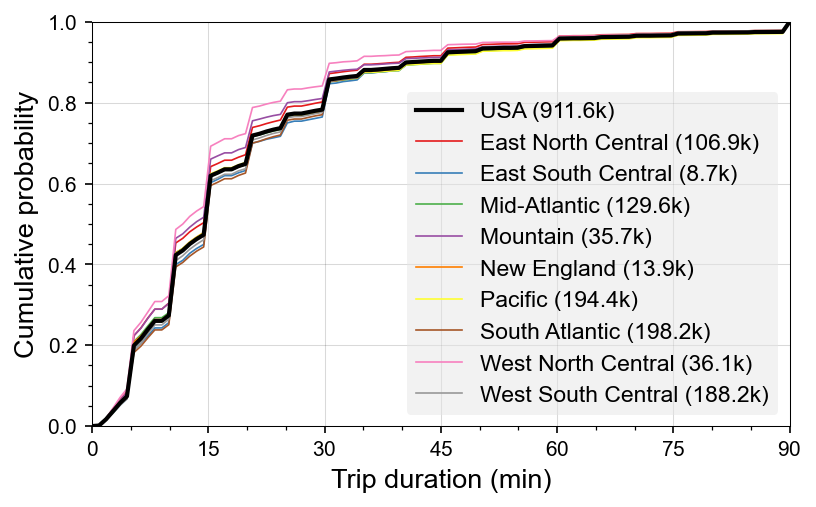

In [5]:
ax = pplot(size=(6, 3.5), xlim=(0, 90), ylim=(0, 1), dpi=150,
           xlab='Trip duration (min)', ylab='Cumulative probability')
# ax.set_title('Trip duration distribution across US region')
def plot_distr(df, label, **kwargs):
    y, x = np.histogram(df['duration'].clip(0, 90), bins=100)
    ax.plot([0] + list(x[1:]), [0] + list((y / y.sum()).cumsum()),
            label=r'{} ({:.1f}k)'.format(label, len(df) / 1e3), **kwargs)
plot_distr(tripUS, color='k', lw=2, ls='-', label='USA', zorder=100)
colors = sns.color_palette('Set1', tripUS['division'].nunique())
for (label, df), color in zip(tripUS.groupby('division'), colors):
    plot_distr(df, lw=0.8, color=color, label=label)
ax.legend()
ax.set_xticks(np.arange(0, 90+1, 15))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5));

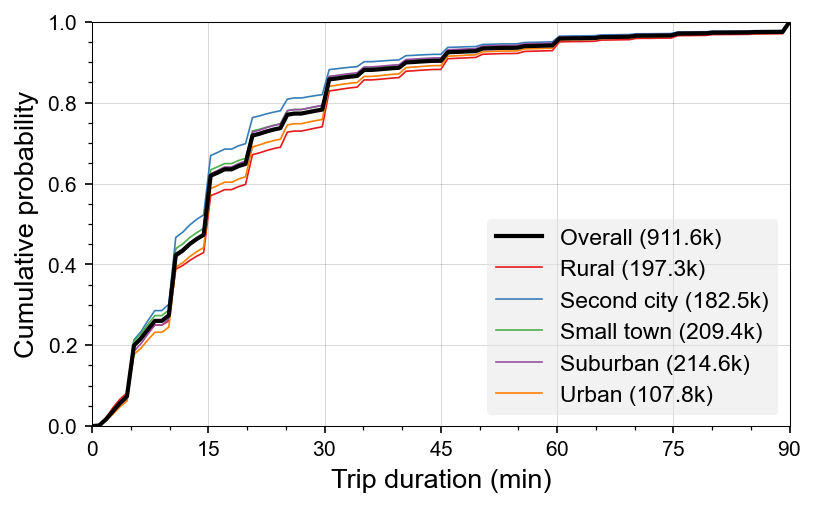

In [6]:
ax = pplot(size=(6, 3.5), xlim=(0, 90), ylim=(0, 1), dpi=150,
           xlab='Trip duration (min)', ylab='Cumulative probability')
# ax.set_title('Trip duration distribution by rurality')
def plot_distr(df, label, **kwargs):
    y, x = np.histogram(df['duration'].clip(0, 90), bins=100)
    ax.plot([0] + list(x[1:]), [0] + list((y / y.sum()).cumsum()),
            label=r'{} ({:.1f}k)'.format(label, len(df) / 1e3), **kwargs)
plot_distr(tripUS, color='k', lw=2, ls='-', label='Overall', zorder=100)
colors = sns.color_palette('Set1', tripUS['bg_rurality'].nunique())
for (label, df), color in zip(tripUS.groupby('bg_rurality'), colors):
    plot_distr(df, lw=0.8, color=color, label=label)
ax.legend()
ax.set_xticks(np.arange(0, 90+1, 15))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5));

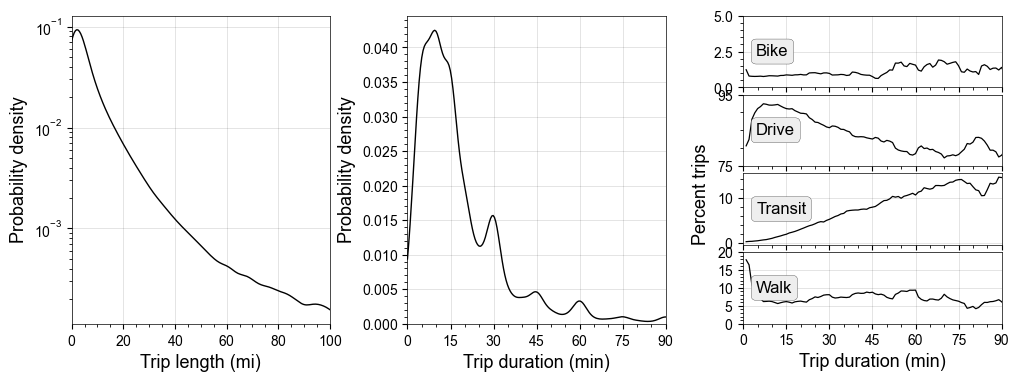

In [7]:
def plot_regional_trip_chars(trip=tripUS, bw_adjust=1.2, dpi=100):
    fig = plt.figure(figsize=(12, 4), dpi=dpi)
    gs = fig.add_gridspec(4, 3, hspace=0.1, wspace=0.3)
    ## Trip length
    ax1 = pplot(fig.add_subplot(gs[:, 0]), xlim=(0, 100), ylog=1,
                xlab='Trip length (mi)', ylab='Probability density')
    sns.kdeplot(trip, ax=ax1, x='distance', bw_adjust=bw_adjust, 
                clip=(0, 100), color='k', lw=1)
    ## Trip duration
    xticks = np.arange(0, 90 + 1, 15)
    ax2 = pplot(fig.add_subplot(gs[:, 1]), xlim=(0, 90),
                xlab='Trip duration (min)', ylab='Probability density')
    sns.kdeplot(trip, ax=ax2, x='duration', bw_adjust=bw_adjust, 
                clip=(0, 90), color='k', lw=1)
    ax2.set_xticks(xticks)
    ax2.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    ## Modal composition by duration
    vmax, smooth = 90, 8
    df = trip.query(f'duration <= {vmax + smooth}')
    df = df.groupby(['mode', 'duration']).size().rename('ntrips')
    df = df.reset_index().pivot_table('ntrips', 'duration', 'mode').fillna(0)
    for i, mode in enumerate(df.columns):
        y = df[mode] / df.sum(1) * 100
        y = y.rolling(smooth).mean()[smooth:]
        y.index = np.arange(1, len(y) + 1)
        ax = fig.add_subplot(gs[i, 2])
        y.plot(ax=ax, color='k', lw=0.9)
        ax.set_xlim(0, 90)
        ax.text(0.05, 0.5, mode.title(), va='center', transform=ax.transAxes,
                fontsize=12, bbox=D(fc='#eee', ec='k', lw=0.2, boxstyle='round'))
        ax.set_xticks(xticks, labels=xticks if i == 3 else [])
        ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
        ymin, ymax = np.floor(y.min() / 5) * 5, np.ceil(y.max() / 5) * 5
        gap = D(drive=20, transit=10, bike=2.5, walk=5)[mode.lower()]
        ax.set_yticks(np.arange(ymin, ymax + 1, gap))
        if i == 2: ax.set_ylabel('Percent trips', labelpad=5, loc='bottom')
        if i == 3: ax.set_xlabel('Trip duration (min)')

plot_regional_trip_chars() # t=0:10

### 3.1.1. Marginal: By region & mode

In [8]:
tripUS.groupby('mode').duration.describe()

,count,mean,std,min,25%,50%,75%,max
mode,,,,,,,,
Bike,8031.0,22.520234,29.114012,-9.0,9.0,15.0,28.0,504.0
Drive,799268.0,20.760745,30.461322,-9.0,8.0,15.0,25.0,1200.0
Transit,23026.0,43.367888,38.660042,-9.0,20.0,30.0,56.0,840.0
Walk,81241.0,17.174949,27.087484,-9.0,5.0,10.0,20.0,1065.0


In [9]:
tripUS.groupby(['mode', 'purpose']).size().rename('size').reset_index()

,mode,purpose,size
0,Bike,Not Home-Based,1668
1,Bike,Other Services,1719
2,Bike,Shopping,1103
3,Bike,Social/Recreational,2325
4,Bike,Work,1216
5,Drive,Not Home-Based,272732
6,Drive,Other Services,152938
7,Drive,Shopping,181387
8,Drive,Social/Recreational,84308
9,Drive,Work,107903


In [10]:
mode_colors = D(Drive='blue', Transit='deeppink', Bike='tomato', Walk='seagreen')

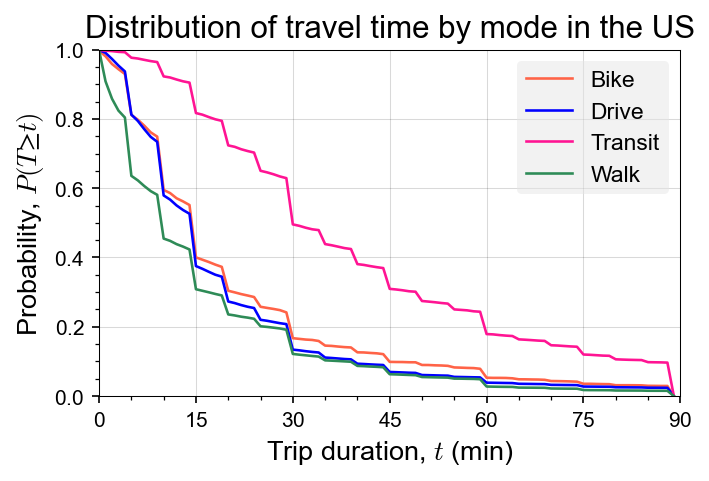

In [11]:
title = 'Distribution of travel time by mode in the US'
ax = pplot(size=(5, 3), title=title, xlab=r'Trip duration, $t$ (min)',
           ylab='Probability, $P(T≥t)$', ylim=(0, 1), xlim=(0, 90))
for mode, df in tripUS.groupby('mode'):
    y, x = np.histogram(df['duration'].clip(0, 90), bins=90)
    x = [0] + list(x[:-1])
    y = [1] + list(1 - (y / y.sum()).cumsum())
    ax.plot(x, y, color=mode_colors[mode], label=mode.title(), lw=1.25)
ax.legend()
ax.set_xticks(np.arange(0, 90 + 1, 15))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5));

### 3.1.2. By purpose

In [12]:
purpose_ls = {'Work': '-', 'Shopping': '--', 'Social/Recreational': '-.', 'Other Services': ':'}

Bike 21.470257114123886
Drive 18.717703204872855
Transit 43.99416881355239
Walk 18.16278062065292


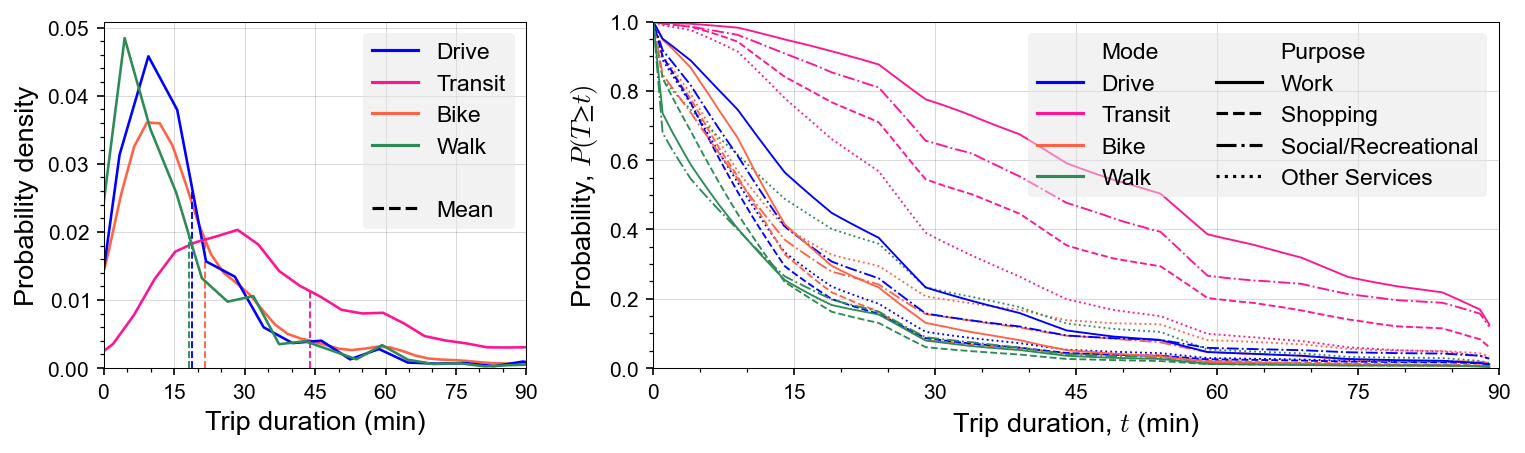

In [13]:
def plot_duration_distr_by_mode_purpose(
        trip=tripUS, vmax=90, smooth=5, 
        linestyles=purpose_ls, colors=mode_colors, dpi=150):
    _, axes = plt.subplots(1, 2, figsize=(12, 3), dpi=dpi,
                           gridspec_kw=D(width_ratios=[1, 2]))
    colors = {k.title(): v for k, v in colors.items()}
    ## (a) Marginal by only mode
    ax1 = pplot(axes[0], xlim=(0, 90))
    # stats = [('Mean', np.mean, '--'), ('Median', np.median, ':')]
    stats = [('Mean', np.mean, '--')]
    for mode, df in trip.groupby('mode'):
        ax1 = sns.kdeplot(df, ax=ax1, x='duration', color=colors[mode], lw=1.25)
        xy = ax1._children[-1]._xy
        for _, func, ls in stats:
            i = np.argwhere(xy[:, 0] < func(df.duration)).flatten()[-1]
            x, y = xy[i:i+2, :].mean(0)
            print(mode, x)
            ax1.plot([x, x], [0, y], color=colors[mode], ls=ls, lw=0.9)
    line = lambda **kw: mpl.lines.Line2D([0], [0], **kw)
    h = ([line(color=c, label=l.title()) for l, c in colors.items()] +
         [line(color='none')] + [line(ls=ls, color='k', label=l) for l, _, ls in stats])
    ax1 = pplot(ax1, xlab='Trip duration (min)', ylab='Probability density')
    ax1.legend(handles=h)
    xticks = np.arange(0, vmax + 1, 15)
    ax1.set_xticks(xticks)
    ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    ## (b) Cumulative by mode & purpose
    ax2 = pplot(axes[1], xlim=(0, 90), ylim=(0, 1),
                 xlab=r'Trip duration, $t$ (min)', ylab=r'Probability, $P(T≥t)$')
    bins = np.arange(vmax + smooth + 1)
    trip = trip.query('purpose != "Not Home-Based"')
    for purpose, df in trip.groupby('purpose'):
        for mode, df2 in df.groupby('mode'):
            y, x = np.histogram(df2['duration'].clip(0, vmax + smooth), bins=bins)
            x = list(x[smooth + 1:] - x[smooth])
            y = Series(1 - (y / y.sum()).cumsum())
            y = list(y.rolling(smooth, center=True, closed='left').mean()[smooth:])
            ax2.plot([0] + x, [1] + y, lw=0.9, color=colors[mode], ls=linestyles[purpose])
            ax2.set_xticks(xticks)
            # for x in [15, 30, 45, 60]:
            #     ax2.axvline(x, color='#333', lw=0.25)
    ax2.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    ax2.legend(handles=[line(alpha=0, label='Mode')] + 
            [line(color=c, label=l.title()) for l, c in colors.items()] + 
            [line(alpha=0, label='Purpose')] +
            [line(color='k', ls=ls, label=l) for l, ls in linestyles.items()],
            loc='upper right', fontsize=11, ncols=2)

plot_duration_distr_by_mode_purpose()

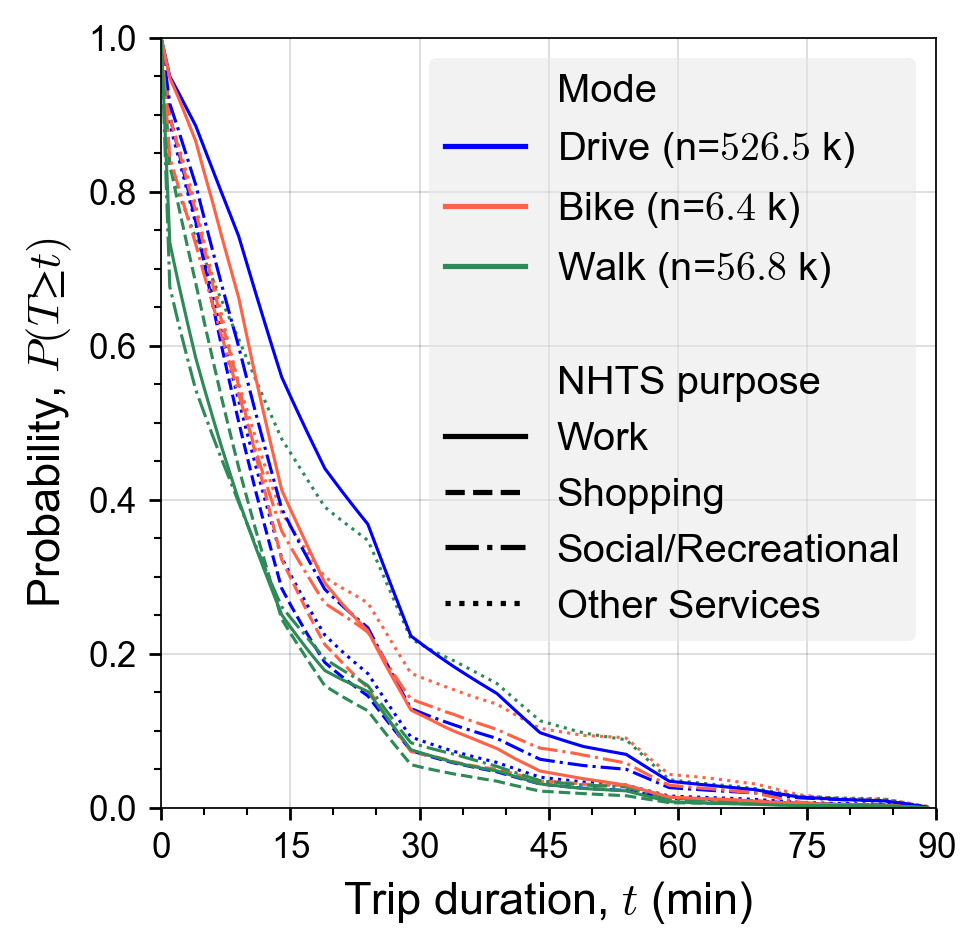

In [14]:
def plot_duration_distr_by_mode_purpose2(trip=tripUS, vmax=90, smooth=5, 
                                         linestyles=purpose_ls, 
                                         colors=mode_colors, dpi=100):
    ax = pplot(size=(4, 4), dpi=dpi, xlim=(0, 90), ylim=(0, 1),
               xlab=r'Trip duration, $t$ (min)', ylab=r'Probability, $P(T≥t)$')
    trip = trip.assign(mode=trip['mode'].str.title())
    colors = {k: v for k, v in colors.items() if k != 'Transit'}
    bins = np.arange(vmax + smooth + 1)
    trip = trip.query('purpose != "Not Home-Based"')
    for purpose, df in trip.groupby('purpose'):
        for mode, color in colors.items():
            vals = df[df['mode'] == mode].duration.clip(0, vmax + smooth + 1)
            y, x = np.histogram(vals, bins=bins)
            x = list(x[smooth + 1:] - x[smooth])
            y = Series(1 - (y / y.sum()).cumsum())
            y = list(y.rolling(smooth, center=True, closed='left').mean()[smooth:])
            ax.plot([0] + x, [1] + y, lw=0.9, color=color, ls=linestyles[purpose])
            ax.set_xticks(np.arange(0, vmax + 1, 15))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    line = lambda **kw: mpl.lines.Line2D([0], [0], **kw)
    n = trip['mode'].str.lower().value_counts().map(mpl.ticker.EngFormatter(places=1))
    ax.legend(handles=[line(alpha=0, label='Mode')] + 
            [line(color=c, label=f'{l.title()} (n={n.loc[l.lower()]})') 
             for l, c in colors.items()] + 
            [line(alpha=0, label=None)] + [line(alpha=0, label='NHTS purpose')] +
            [line(color='k', ls=ls, label=l) for l, ls in linestyles.items()],
            loc='upper right', fontsize=11.5, ncols=1)

plot_duration_distr_by_mode_purpose2(dpi=250)

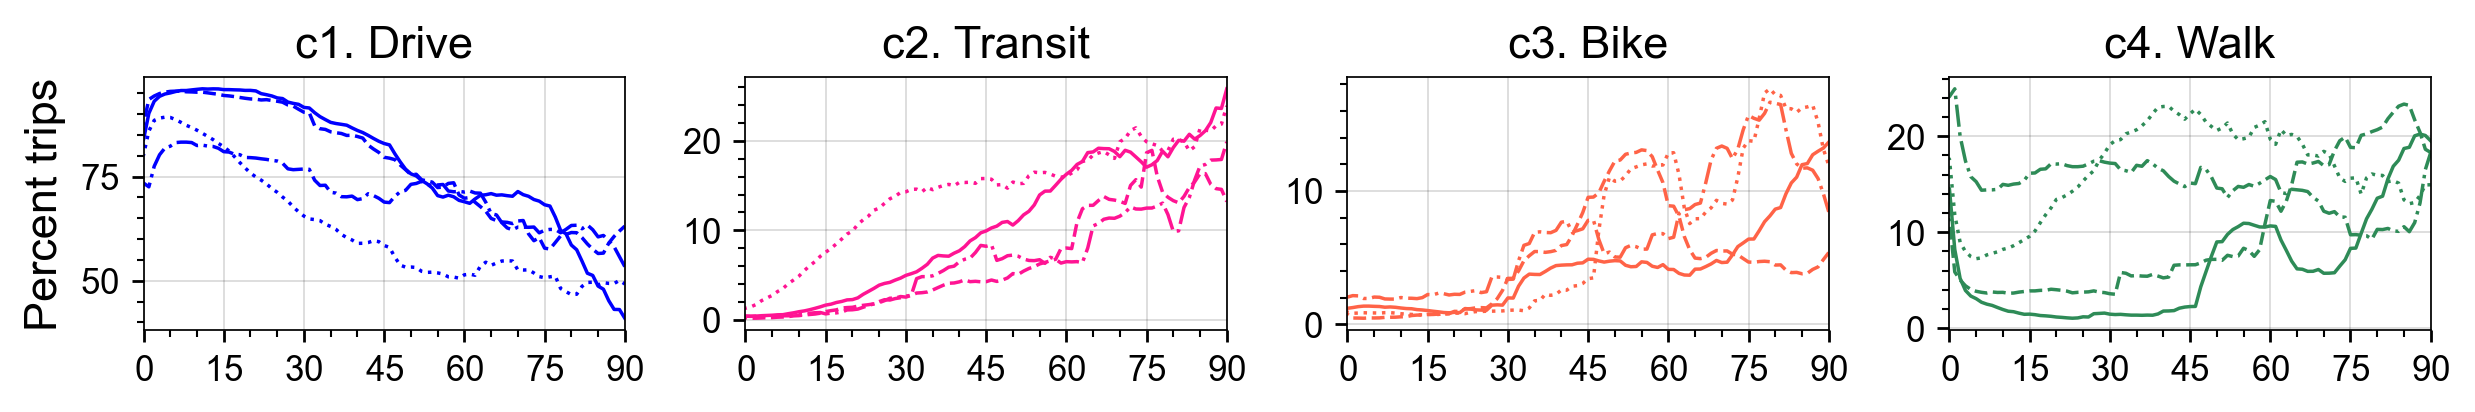

In [15]:
def plot_mode_composition(trip=tripUS, vmax=90, smooth=15, dpi=100,
                          colors=mode_colors, linestyles=purpose_ls):
    _, axes = plt.subplots(1, 4, figsize=(10, 1.75), dpi=dpi)
    trip = (trip.groupby(['mode', 'purpose', 'duration']).size()
            .rename('ntrips').reset_index()
            .pivot_table('ntrips', 'duration', ['mode', 'purpose'])
            .interpolate().fillna(0).reset_index()
            .melt('duration', value_name='ntrips'))
    for purpose, ls in linestyles.items():
        df = trip.query(f'purpose=="{purpose}"')
        df = df.pivot_table('ntrips', 'duration', 'mode')
        for i, (mode, color) in enumerate(colors.items()):
            y = df[mode] / df.sum(1) * 100
            y = y[y.index <= vmax + smooth][::-1].rolling(smooth).mean()[smooth:][::-1]
            ax = pplot(axes[i], xlim=(0, vmax), ylab='Percent trips' if i == 0 else '')
            ax.set_title(f'c{i+1}. {mode}', fontsize=13)
            y.plot(ax=ax, color=color, ls=ls, lw=1, label=purpose)
            ax.set_xticks(np.arange(0, vmax + 1, 15))
            ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
            ax.set_xlabel('')
    plt.tight_layout()

plot_mode_composition(dpi=250) # t=0:10

## 3.2. Fit decay functions

### 3.2.1. Select the functional form

In [16]:
def fit_decay_func(values, func, method='lm', bin_interval=1):
    bins = np.arange(0, np.max(values) + 1, bin_interval)
    y, x = np.histogram(values, bins=bins)
    x, y = x[1:], 1 - (y / y.sum()).cumsum()
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        params = curve_fit(func, x, y, method=method)[0]
        yfit = func(x, *params)
    r2 = 1 - ((yfit - y)**2).sum() / ((y - y.mean())**2).sum()
    return params, r2

fit_decay_func(tripUS.query('mode=="Transit" & purpose=="Work"')
               ['duration'].clip(0, 180), lambda x, a, b: np.exp(-a * x ** b))

(array([2.97490447e-04, 1.91881971e+00]), 0.9973560681040111)

In [17]:
def fit_decay_functions(func, trips, cols=(('duration', 90), ('distance', 100))):
    res = []
    for mode, df in trips.groupby('mode'):
        if mode == 'Transit': continue
        for col, vmax in cols:
            params, r2 = fit_decay_func(df[col].clip(0, vmax), func)
            if r2 < 0 or r2 > 1: continue
            res.append(D(mode=mode, col=col, r2=r2) | D(zip('αβ', params)))
    return Pdf(res)

power_exp = lambda x, a, b: np.exp(-a*(x**b))
fit = fit_decay_functions(power_exp, tripUS).disp(None)

6 rows x 5 cols; Memory: 0.0 MiB


,mode,col,r2,α,β
,<object>,<object>,<float64>,<float64>,<float64>
0,Bike,duration,0.982776,0.029938,1.145489
1,Bike,distance,0.98556,0.621682,0.748183
2,Drive,duration,0.984849,0.022773,1.268819
3,Drive,distance,0.987207,0.248031,0.733724
4,Walk,duration,0.991288,0.065718,0.978846
5,Walk,distance,0.998607,1.599004,0.67357


### 3.2.2. Fit parameters

In [18]:
def fit_params(trips=tripUS, func=lambda x, a, b: np.exp(-a*(x**b)),
               cols=(('duration', 90), ('distance', 100))):
    outpath = DATA / 'impedance/fitted-params.csv'
    res = []
    trips = trips.query('purpose != "Not Home-Based"')
    for col, vmax in cols:
        for mode, df in trips.groupby('mode'):
            # if mode == 'Transit': continue
            (a, b), r2 = fit_decay_func(df[col].clip(0, vmax), func)
            res.append((mode.title(), 'Overall', col.title(), a, b, r2))
            for purpose, df2 in df.groupby('purpose'):
                (a, b), r2 = fit_decay_func(df2[col].clip(0, vmax), func)
                if r2 < 0 or r2 > 1: continue
                res.append((mode.title(), purpose.title(), col.title(), a, b, r2))
    res = Pdf(res, columns=['mode', 'purpose', 'measure', 'alpha', 'beta', 'r2'])
    df = res.melt(['measure', 'mode', 'purpose'], var_name='parameter')
    df.to_csv(mkfile(outpath), index=False)
    pivot = df.query('measure=="Duration"').copy()
    pivot.purpose = pd.Categorical(pivot.purpose, categories=[
        'Overall', 'Work', 'Shopping', 'Social/Recreational', 'Other Services'])
    pivot['mode'] = pd.Categorical(pivot['mode'], categories=['Drive', 'Walk', 'Bike'])
    pivot = pivot.pivot_table('value', 'purpose', ['parameter', 'mode'])
    disp_table(pivot, [D(selector='td, th', props=[
        ('border', '1px solid grey !important'), ('text-align', 'left')])])
    return df

x = fit_params()#; x